# SECS implementation i Python

Create a figure illustrating Python implementation spherical elementary current system (SECS) analysis on a cubed sphere grid (Figure 3 in paper).

Import relevant modules:

In [1]:
import lompe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lompe.secsy import get_SECS_B_G_matrices

Re = 6371.2e3    # Earth radius
HI = 110e3       # Ionospheric altitude

Set up cubed sphere (CS) projection and grid:

In [2]:
L, W, Lres, Wres = 20000e3, 20000e3, 100e3, 100e3
projection = lompe.cs.CSprojection(position = (0, 90), orientation = 0)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R = Re+HI) # set grid to ionospheric altitude

We can visualize by plotting grid and coastlines:

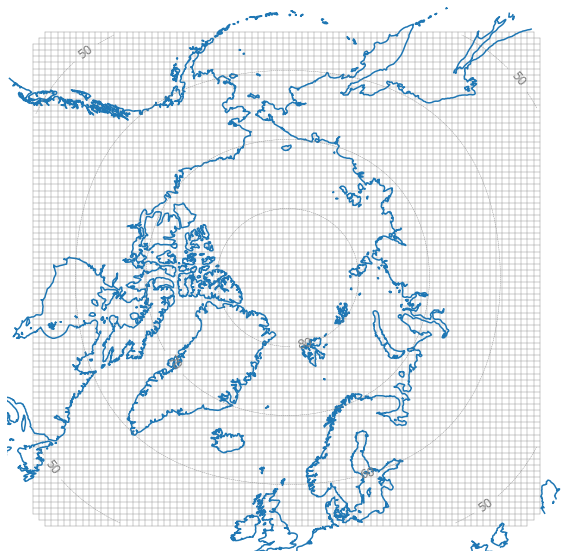

In [3]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_axis_off()

# grid
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

# coastlines
xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'C0')

# add (geographic) latitude contours
co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
ax.clabel(co, co.levels, inline = True, fontsize = 12)

ax.set_xlim(xlim)
ax.set_ylim(ylim);

For this example, we chooe to set the Pedersen $\Sigma_P$ and Hall $\Sigma_H$ conductances to a constant $10\ \mathrm{moh}$ across the entire grid:

In [4]:
SH = np.ones(grid.shape)*10 # moh
SP = np.ones(grid.shape)*10 # moh

In notebook 01, we calculated the divergence of the ionospheric electric field $\nabla\cdot\mathbf{E}$ from an electrostatic "Weimer" potential $\Phi$. We want to use this divergence to represent FACs, $j_{||}$. We have conductances that are constant across the grid, and therefore no gradients of the Pedersen and Hall conductance. Thus the FACs and $\nabla\cdot\mathbf{E}$ can be related through:

\begin{equation*}
    J_{||} = \Sigma_P\nabla\cdot\mathbf{E}
\end{equation*}
([Reistad et al. 2019](https://doi.org/10.1029/2019JA026634)). $\sigma$ is area.

NOTE: $\nabla\times\mathbf{E}=0$ is assumed.

We load the $\nabla\cdot\mathbf{E}$ from the file saved from notebook 01 (note that the cubed sphere grids are the same):

In [5]:
df = pd.read_hdf('./datasets/01divE.h5')
divE = (df['divE'].values).reshape(grid.shape) # to numpy array with shape matching 
FAC = divE*SH

FACs are related to curl-free (CF) amplitudes of SECS basis functions, $\mathbf{S}^{\star}$:
\begin{equation*}
    \mathbf{S}^{\star}=j_{||}\cdot A
\end{equation*}

In [6]:
CF_ampl = FAC*grid.A

As $\sigma_P$ and $\Sigma_H$ have a ratio of 1, the CF amplitudes and divergence-free (DF) SECS amplitudes $\mathbf{S}^{\circ}$ also have the ratio of 1:

    TODO: Amm 2002 - eq. 5, doi: 10.1029/2002JA009472

And we therefore also obtain $\mathbf{S}^{\circ}$:

In [7]:
DF_ampl = CF_ampl

The SECS amplitudes are defined on our CS grid.

The DF current are what can be observed as magnetic disturbances on ground $\Delta\tilde{\mathbf{B}}_g$, and we relate $\mathbf{S}^{\circ}$ to these disturbances through:
\begin{equation*}
    \Delta\tilde{\mathbf{B}}_g=\mathbb{H}^{\circ}_g\mathbf{S}^{\circ}
\end{equation*}

We use the vectorized implementation of the SECS basis functions to find the matrix $\mathbb{H}^{\circ}_g$ that resates these DF amplitudes to the magnetic field on ground:

In [8]:
# limit for singularity correction is half a grid cell
secs_singularity_limit = np.min([grid.Wres, grid.Lres])/2

He_mat, Hn_mat, Hu_mat = get_SECS_B_G_matrices(np.ravel(grid.lat_mesh), np.ravel(grid.lat_mesh), Re, 
                                               np.ravel(grid.lat), np.ravel(grid.lon), RI = grid.R,
                                               current_type = 'divergence_free', 
                                               singularity_limit = secs_singularity_limit)

We set radius of evaluation points to be on ground (at Earth radius) slightly offset from the grid centers and specify where the altitude of the SECS amplitudes.

We can then calculate the magntic field disturbances on ground resulting from the FACs calculated from the Weimer potential:

In [9]:
Bge, Bgn, Bgu = He_mat.dot(DF_ampl.flatten()), Hn_mat.dot(DF_ampl.flatten()), Hu_mat.dot(DF_ampl.flatten())

We can visualize the ground magnetic field using the implemented plotting functions fro visualization:

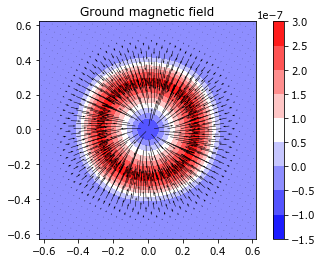

In [20]:
# set up figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Ground magnetic field')

#plot_quiver(  ax, model, 'ground_mag') # east, north
scale = 600 * 1e-9 # ground magnetic field scale [T]
colorscale = np.linspace(-980, 980, 50) * 1e-9 / 3 # upward component
scale_units = 'inches'

# assuming grid_J is inner grid (eval??)

# for setting up a coarser grid for arrows
#sh = np.array(grid.shape)
#NN = 12 # number of arrows to plot along smallest dimension
#sh = sh // sh.min() * NN 
#ximin  = grid.xi. min() + grid.dxi  / 3
#ximax  = grid.xi. max() - grid.dxi  / 3
#etamin = grid.eta.min() + grid.deta / 3
#etamax = grid.eta.max() - grid.deta / 3

#xi, eta = np.meshgrid(np.linspace(ximin, ximax, sh[1]), np.linspace(etamin, etamax, sh[1]))
lo, la = grid.projection.cube2geo(grid.xi_mesh, grid.eta_mesh)
x, y, Ax, Ay = grid.projection.vector_cube_projection(Bge.reshape(lo.shape), Bgn.reshape(lo.shape), lo, la)

if Bgu.size == grid.xi.size:
    xi, eta, z = grid.xi , grid.eta , Bgu.reshape(grid.shape)
else:
    xi, eta, z = grid.xi_mesh, grid.eta_mesh, Bgu.reshape(grid.eta_mesh.shape)
c=ax.contourf(xi, eta, z, cmap='bwr')
ax.set_aspect('equal')
plt.colorbar(c)
ax.quiver(x[::5], y[::5], Ax[::5], Ay[::5], scale = scale, units=scale_units, color = 'black')
#func = getattr(model, funcs[dtype])
#sh = np.array(model.grid_J.shape)

# get function values on plotting grid:
#sh = sh // sh.min() * NN 
#ximin  = model.grid_J.xi .min() + model.grid_J.dxi  / 3
#ximax  = model.grid_J.xi .max() - model.grid_J.dxi  / 3
#etamin = model.grid_J.eta.min() + model.grid_J.deta / 3
#etamax = model.grid_J.eta.max() - model.grid_J.deta / 3
#xi, eta = np.meshgrid(np.linspace(ximin, ximax, sh[1]), np.linspace(etamin, etamax, sh[1]))
#lo, la = model.grid_J.projection.cube2geo(xi, eta)
#A = func(lon = lo, lat = la)
#if len(A) == 2:
    #Ae, An = A
#if len(A) == 3:
    #Ae, An, Au = A 
#x, y, Ax, Ay = model.grid_J.projection.vector_cube_projection(Ae, An, lo, la)
#ax.quiver(x, y, Ax, Ay, **kwargs)

#plot_contour( ax, model, 'ground_mag', vertical = True) # up


pax = lompe.model.visualization.Polarsubplot(ax, minlat = 50, plotgrid = True, sector = 'all')

# convert coordinates to magnetic latitude and MLT
a = Apex(dt.now(), HI*1e-3)
mlat, mlon, _ = a.geo2apex(grid.lat, grid.lon, HI*1e-3)
mlt = a.mlon2mlt(mlon)

# specs for plotting tools
scale = 600 * 1e-9 # ground magnetic field scale [T]
colorscale = np.linspace(-980, 980, 50) * 1e-9 / 3 # upward component
scale_units = 'inches'

# coastlines
shpfilename = shpreader.natural_earth(resolution='110m', category='physical', name='coastline')
reader = shpreader.Reader(shpfilename)
coastlines = reader.records()
multilinestrings = []
for coastline in coastlines:
    if coastline.geometry.geom_type == 'MultiLineString':
        multilinestrings.append(coastline.geometry)
        continue

    lon, lat = np.array(coastline.geometry.coords[:]).T
    mlat, mlon = apex.geo2apex(lat, lon, HI*1e-3)
    mlon[mlat < 50] = np.nan
    mlat[mlat < 50] = np.nan
    if np.sum(np.isfinite(mlat)) > 2:
        mlt = np.full_like(mlon, np.nan)
        mlt[np.isfinite(mlon)] = apex.mlon2mlt(mlon[np.isfinite(mlon)], dt.now())
        pax.plot(mlat, mlt, color='lightgrey', linewidth=2, zorder=1)

for mls in multilinestrings:
    for ls in mls:
        lon, lat = np.array(ls.coords[:]).T 
        mlat, mlon = apex.geo2apex(lat, lon, HI*1e-3)
        mlon[mlat < 50] = np.nan
        mlat[mlat < 50] = np.nan
        if np.sum(np.isfinite(mlat)) > 2:
            mlt = np.full_like(mlon, np.nan)
            mlt[np.isfinite(mlon)] = apex.mlon2mlt(mlon[np.isfinite(mlon)], dt.now())
            pax.plot(mlat, mlt, color='lightgrey', linewidth=2, zorder=1)

# rotate east, north magnetic field disturbances to magnetic system


# plot Bg:
pax.plotpins(mlat, mlt, mBgn.reshape(mlat.shape), mBge.reshape(mlat.shape), SCALE = scale, size = 10, unit = scale_units, color = 'black', 
             markercolor = 'black', marker = '*', markersize = 10)
c=pax.contourf(mlat, mlt, Bgu.reshape(mlat.shape), cmap='bwr', levels=levels, extend='both')


plot_quiver(  ax, model, 'ground_mag')
plot_contour( ax, model, 'ground_mag', vertical = True)


    
    # adjust spacing between axes
    plt.subplots_adjust(wspace=0.09, left=0.01, right=1.1, bottom=0 , top=.9)

    # color bar
    fig.colorbar(c, ax=[ax1,ax2], label = '[moh]', ticks=ticks, orientation='vertical', shrink=0.7, aspect=25)